# Home Credit - Feature Engineering

In the last EDA notebook, 
1. We had a detailed look at features
2. And their relationship with target variable.

Based on above analysis and common sense, we will create additional features which might be useful in predicting credit default. We have created new features in Data Wrangling when we combined Bureau data and Home Credit Historical data with current application data. This notebook focuses on adding more features based on EDA analysis and current application data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from scipy import stats

from pathlib import Path

%matplotlib inline
%precision %.2f

plt.style.use('bmh')
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 100)

In [2]:
train_path = '../data/interim/df_train_dimR.csv'
test_path = '../data/interim/df_test_dimR.csv'
dtype_path = '../data/interim/data_types.csv'

In [3]:
df_train = pd.read_csv(train_path,index_col=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215249 entries, 0 to 215248
Columns: 177 entries, sk_id_curr to bc_cnt_cr_status_others
dtypes: float64(109), int64(41), object(27)
memory usage: 292.3+ MB


Getting the data types of variables

In [4]:
df_dtype = pd.read_csv(dtype_path,index_col=0)
dict_dtype = df_dtype.dtype.to_dict()

Converting dataset to optimize memory usage based on EDA analysis.

In [5]:
df_train = df_train.astype(dict_dtype)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215249 entries, 0 to 215248
Columns: 177 entries, sk_id_curr to bc_cnt_cr_status_others
dtypes: float16(90), float64(19), int64(6), int8(34), object(28)
memory usage: 132.6+ MB


Now we will create additional features

### Application details based features    


In [6]:
# listing all the indicators for various document availability
document_features = ['flag_document_2', 'flag_document_3', 'flag_document_4', 'flag_document_5', 'flag_document_6',
       'flag_document_7', 'flag_document_8', 'flag_document_9', 'flag_document_10', 'flag_document_11', 
        'flag_document_12', 'flag_document_13', 'flag_document_14', 'flag_document_15', 'flag_document_16', 
        'flag_document_17', 'flag_document_18', 'flag_document_19', 'flag_document_20', 'flag_document_21']

def crt_application_features(df):
    """
    Create new featues based on application details
    df - train/test dataset
    """
    
    df['rt_annuity_credit'] = df.amt_annuity/df.amt_credit            # annuity to credit may indicate paying capability
    df['rt_goods_price_credit'] = df.amt_goods_price/df.amt_credit    # goods price to credit may indicate paying capability
    df['rt_credit_income'] = df.amt_credit/df.amt_income_total        # income is declared but not verified
    df['rt_annuity_income'] = df.amt_annuity/df.amt_income_total      # annuity to income may indicate paying capability
    df['total_document_flags'] = df[document_features].sum(axis=1)    # indicates completeness of application
    
    return df

In [7]:
df_train_fe = df_train.copy()
df_train_fe = crt_application_features(df_train_fe)

### Applicant's details based features

In [8]:
def crt_applicant_features(df):
    """
    Create new featues based on applicant's details
    df - train/test dataset
    """
    
    df['rt_days_employed_birth'] = df.days_employed/df.days_birth              # employement years to age in days 
    df['rt_days_id_birth'] = df.days_id_publish/df.days_birth                  # id published to age in days
    df['rt_phone_changed_birth'] = df.days_last_phone_change/df.days_birth     # behavioral factor which may indicate trust
    df['avg_family_income'] = df.amt_income_total/df.cnt_fam_members           # income per family member
    df['avg_family_credit'] = df.amt_credit/df.cnt_fam_members                 # credit per family member
    df['total_contact_flags'] = df.flag_mobil + df.flag_work_phone + df.flag_cont_mobile + df.flag_phone + df.flag_email
    
    return df

In [9]:
df_train_fe = crt_applicant_features(df_train_fe)

In [10]:
df_train_fe.shape

(215249, 188)

In [11]:
# to save plots
p = Path.cwd().parent / 'reports' / 'figures'
suffix ='.pdf'

In [12]:
# From Pandas Cookbook 1.X
def flatten_cols(df):
    df.columns = ['_'.join(x) for x in
        df.columns.to_flat_index()]
    return df

# To plot continuous features. We first convert continuous feature into suitable bins.
# Then we plot bins on x-axis, default rate on primary y-axis & number of observations on secondary y axis.
# Plotting number of observations indicated the credibility of default rate.

def plot_default_cont_feat(df, var, var_desc, n = 10, pct_range = (0.0,1.0), decimals = 0 ):
    """
    Plot default rate for continuous feature. We bin continuous feature & then plot default rate & count of observation.
    
    Keyword arguments:
    df -- DataFrame
    var -- categorical feature to be grouped by
    var_desc -- description of the feature to be displayed as label 
    n -- number of bins
    pct_range -- percentile range used for plotting. Values outside this range will be excluded.
    decimals -- to tune number of bins. eg if a feature has [0,1] range, then decimal is 
                atleast 2 to avoid duplicate bins.
                
    """
    df_temp = df[[var,'target','sk_id_curr']].copy()
    l_pct = pct_range[0]
    u_pct = pct_range[1]
    f_min = df_temp[var].quantile(l_pct) - 1/(10**decimals) # 0.01 added to that lower value is not excluded
    f_max = df_temp[var].quantile(u_pct) + 1/(10**decimals)
    mod_var = 'mod'+'_'+ var
    intvl = pd.interval_range(start=f_min, end= f_max, periods= n)
    # Round lower and upper limits of interval
    intvl = pd.IntervalIndex([ pd.Interval( round(i.left,decimals), 
                                round(i.right,decimals), i.closed ) for i in intvl ])
    df_temp.loc[:,mod_var]= pd.cut(df_temp[var],intvl)
    print('Count of missing observations : {}'.format(df_temp.loc[:,var].isna().sum()))
    excluded_obs = df_temp.loc[:,mod_var].isna().sum() - df_temp.loc[:,var].isna().sum()
    print('Count of excluded observations: {}'.format(excluded_obs))
    df_grouped = df_temp.groupby(mod_var,dropna=False).agg({'target':['mean'],'sk_id_curr':['count']}).pipe(flatten_cols)
    del df_temp  
    with plt.style.context('bmh'):
        # plotting default rate on primary y-axis
        fig, ax = plt.subplots()
        fig.set_size_inches(9,6)
        
        plt.xticks(rotation=45, ha='right')
        ax.plot(df_grouped.index.astype('str'), df_grouped.target_mean, 'o--', color= 'red',alpha=0.6)
        ax.set_title('Default Rate by '+var_desc)
        ax.set_ylabel('Default Rate')
        ax.set_xlabel(var_desc)
        ax.set_facecolor('lavenderblush') #background color
        
        # setting the y-axis limit
        ax.set_ylim(ymin=0,ymax=df_grouped.target_mean.max()+0.05)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.1%}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(5, 5), textcoords="offset points",
                        fontsize=10,color = 'red',ha='center', va='bottom') 
        
        # plotting count of records on secondary y-axis
        ax2 = plt.twinx()
        ax2.bar(df_grouped.index.astype('str'),df_grouped.sk_id_curr_count,
                    alpha=0.3, color='sandybrown')
        ax2.set_ylabel('Counts')
        ax2.grid(False)
        
        # Add legends for both y axes
        # source: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        # https://mpltest2.readthedocs.io/en/stable/gallery/recipes/transparent_legends.html
        fig.legend(labels=('Default Rate','Counts'),loc='upper right',bbox_to_anchor=(1,1),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.2)
        sns.despine(left=True,bottom=True,)
        plt.tight_layout()
        plt.savefig(p / (var_desc+'.pdf') )
        plt.show();

Count of missing observations : 0
Count of excluded observations: 0


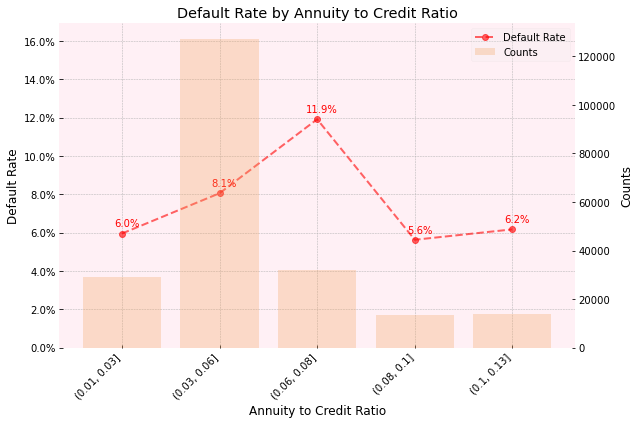

In [13]:
plot_default_cont_feat(df_train_fe,'rt_annuity_credit','Annuity to Credit Ratio', n=5, decimals=2, pct_range=(0.0, 0.99))

Interestingly, we have better loan paying capability at tails and higher default rate in the middle.

Count of missing observations : 192
Count of excluded observations: 1950


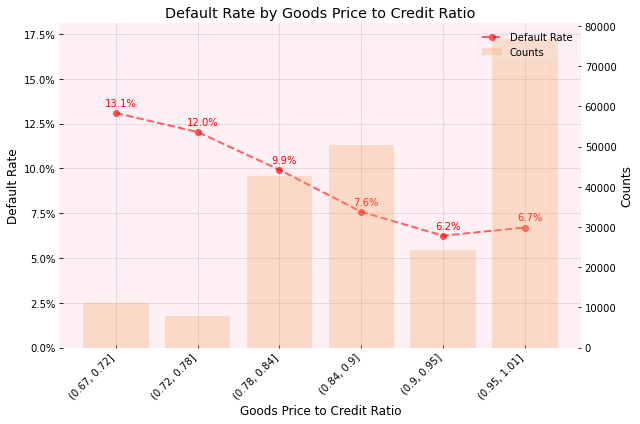

In [14]:
plot_default_cont_feat(df_train_fe,'rt_goods_price_credit','Goods Price to Credit Ratio', 
                       n=6, decimals=2, pct_range=(0.01, 0.99))

Default rate decreases with increase in goods price to credit ratio. This may indicate that underwriting practices are strong when higher risks are given lower amounts(as % of goods price). We do not have a bifurcation of credit into different components (eg insurance costs, downpayments, processing fees etc). This bifurcation may help in interpretation.

Count of missing observations : 38881
Count of excluded observations: 1470


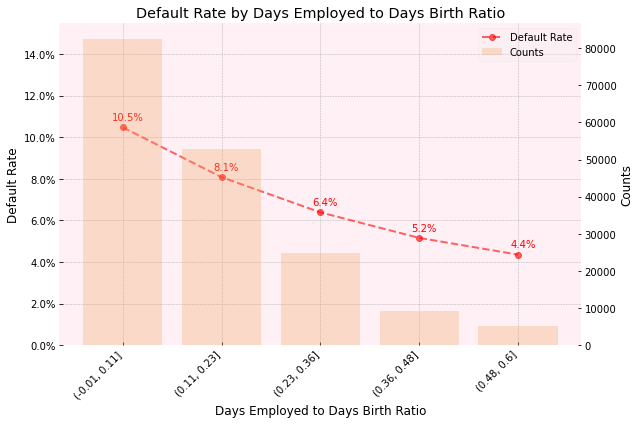

In [15]:
plot_default_cont_feat(df_train_fe,'rt_days_employed_birth','Days Employed to Days Birth Ratio', 
                       n=5, decimals=2, pct_range=(0.0, 0.99))

Higher the proportion of days employed to days birth, lower the default rate. 

Count of missing observations : 1
Count of excluded observations: 1768


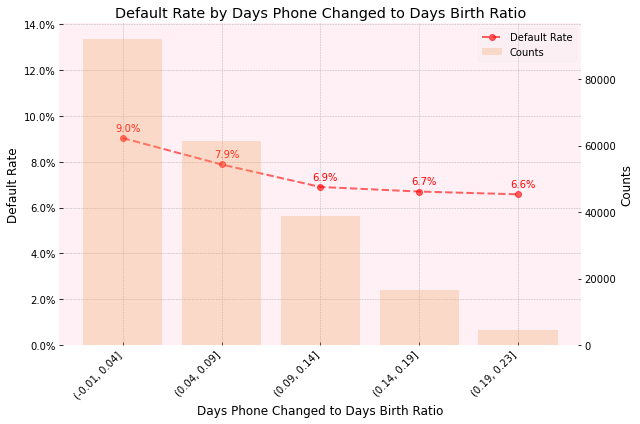

In [16]:
plot_default_cont_feat(df_train_fe,'rt_phone_changed_birth','Days Phone Changed to Days Birth Ratio', 
                       n=5, decimals=2, pct_range=(0.0, 0.99))

Recent changes in phone number is associated with higher default rate.

Count of missing observations : 1
Count of excluded observations: 4100


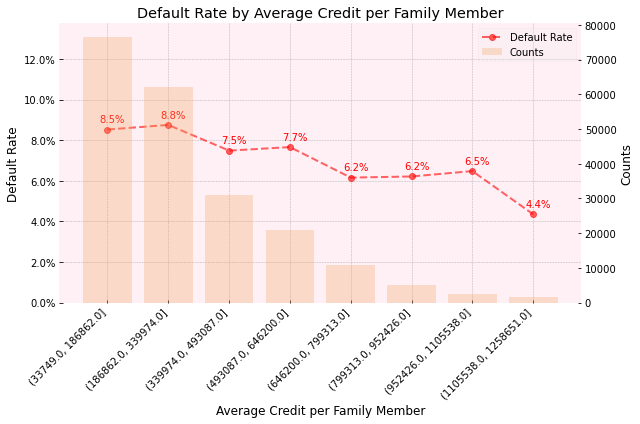

In [17]:
plot_default_cont_feat(df_train_fe,'avg_family_credit','Average Credit per Family Member', 
                       n=8, decimals=0, pct_range=(0.01, 0.99))

Smaller credit per family member indicates higher default rate. This maybe be because of higher expenses incurred in bigger family size.

Repeating same steps for test data

In [18]:
df_test = pd.read_csv(test_path,index_col=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92250 entries, 0 to 92249
Columns: 177 entries, sk_id_curr to bc_cnt_cr_status_others
dtypes: float64(109), int64(41), object(27)
memory usage: 125.3+ MB


In [19]:
df_test = df_test.astype(dict_dtype)

df_test_fe = df_test.copy()
df_test_fe = crt_application_features(df_test_fe)
df_test_fe = crt_applicant_features(df_test_fe)

In [20]:
(df_test_fe.dtypes == df_train_fe.dtypes).sum()

188

In [21]:
train_path = '../data/interim/df_train_fe.csv'
df_train_fe.to_csv(train_path)

test_path = '../data/interim/df_test_fe.csv'
df_test_fe.to_csv(test_path)


In [22]:
df_data_types = pd.DataFrame(df_train_fe.dtypes, columns=['dtype'])

dtype_path = '../data/interim/data_types_fe.csv'
df_data_types.to_csv(dtype_path)

### Next Step - Modelling

Now the dataset is ready for modelling. in the next notebook, we will target an evaluation matric and train different models for maximum performance. Finally, we will analyze the business impact of the best model.